<h1 style="text-align:center">DeLoHA*</h1>

En este notebook implementaremos $\text{DeLoHA}^*$ y entrenaremos una red neuronal con base en los datos recolectados

### Carga de librerías

In [1]:
import math
import random
import heapq
import osmnx as ox
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

### Carga del grafo

El grafo asociado a Bogotá tiene el nombre de "*Bogotá Distrito Capital - Municipio*" interno en la librería:

In [2]:
place_name = "Bogotá Distrito Capital - Municipio"
G = ox.graph_from_place(place_name, network_type="drive")

### Preparación del grafo

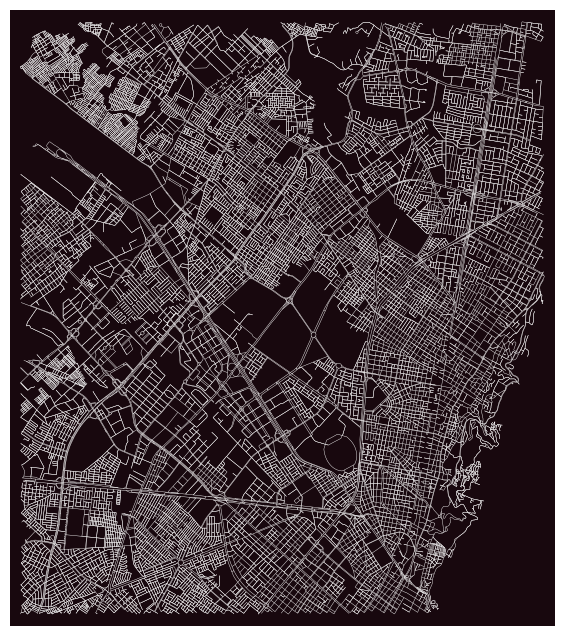

In [3]:
def truncateGraph(G, north=None, south=None, west=None, east=None):
    nodes_to_remove = []

    for node, data in G.nodes(data=True):
        if (north is not None and data['y'] > north) or \
           (south is not None and data['y'] < south) or \
           (east is not None and data['x'] > east) or \
           (west is not None and data['x'] < west):
            nodes_to_remove.append(node)

    G.remove_nodes_from(nodes_to_remove)
    return G 
 
G = truncateGraph(G, west=-74.14604, east = -74.04347, south = 4.60491, north=4.72049)
ox.plot.plot_graph(G, bgcolor="#18080e", edge_color="w", edge_linewidth=0.3, node_size=0);

### Limpieza del grafo

El valor del atributo *maxspeed* de cada arista puede no existir (`None`), puede estar en tipo *string* o puede ser una lista con varios valores. A continuación, arreglamos este inconveniente e incluimos el atributo `weight` que representará el tiempo que se toma en recorrer una arista (distancia sobre velocidad):

In [4]:
for edge in G.edges:
    # Cleaning the "maxspeed" attribute, some values are lists, some are strings, some are None
    maxspeed = 40
    if "maxspeed" in G.edges[edge]:
        maxspeed = G.edges[edge]["maxspeed"]
        if type(maxspeed) == list:
            speeds = [ int(speed) for speed in maxspeed ]
            maxspeed = min(speeds)
        elif type(maxspeed) == str:
            maxspeed = int(maxspeed)
    G.edges[edge]["maxspeed"] = maxspeed
    
    # Adding the "length" attribute
    if "length" not in G.edges[edge] or ("length" in G.edges[edge] and G.edges[edge]["length"] is None):
        G.edges[edge]["length"] = float(ox.distance.great_circle_vec(G.nodes[edge[0]]["y"], G.nodes[edge[0]]["x"], G.nodes[edge[1]]["y"], G.nodes[edge[1]]["x"]))
    # Adding the "weight" attribute (time = distance / speed)
    G.edges[edge]["weight"] = (G.edges[edge]["length"] / 1000) / maxspeed

### Funciones útiles

In [5]:
def haversine_time(node1, node2):
    # Obtener latitudes y longitudes en radianes
    lat1, lon1 = math.radians(G.nodes[node1]["y"]), math.radians(G.nodes[node1]["x"])
    lat2, lon2 = math.radians(G.nodes[node2]["y"]), math.radians(G.nodes[node2]["x"])
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    R = 6378  # Radio de la Tierra en km
    distance_k = float(R * c)
    max_speed=60
    return (distance_k / max_speed)

def haversine_distance(node1, node2):
  # Retorna la distancia en km entre dos nodos (usando coordenadas en G)
  lat1 = math.radians(G.nodes[node1]["y"])
  lon1 = math.radians(G.nodes[node1]["x"])
  lat2 = math.radians(G.nodes[node2]["y"])
  lon2 = math.radians(G.nodes[node2]["x"])
  dlat = lat2 - lat1
  dlon = lon2 - lon1
  a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
  c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
  R = 6378
  return R * c

In [6]:
# Preprocesar coordenadas de todos los nodos
nodes = list(G.nodes)
coords = np.array([(G.nodes[n]["x"], G.nodes[n]["y"]) for n in nodes])
kdtree = KDTree(coords)

def get_local_window(node, K_km):
    """Obtiene nodos dentro de un radio K_km del nodo dado."""
    point = np.array([[G.nodes[node]["x"], G.nodes[node]["y"]]])
    indices = kdtree.query_ball_point(point, r=K_km/6378.0 * (180/np.pi))[0]  # Convertir km a grados
    return [nodes[i] for i in indices]

### DeLoHA*

In [7]:
# --- Clase State para la búsqueda ---
class State:
  def __init__(self, node_id):
    self.id = node_id       # clave del nodo en G
    self.x = G.nodes[node_id]["x"]
    self.y = G.nodes[node_id]["y"]
    self.g = float('inf')   # costo acumulado (tiempo)
    self.f = float('inf')   # f = g + h
    self.parent = None      # puntero al padre

  def __lt__(self, other):
    return self.f < other.f

  def __hash__(self):
    return hash(self.id)

  def __eq__(self, other):
    return self.id == other.id

In [8]:
# --- Definición de heurística global y funciones auxiliares ---
def global_heuristic(state, goal):
  # Se utiliza la función haversine_time con los identificadores de los nodos
  # return haversine_time(state.id, goal.id)
  return haversine_time(state.id, goal.id)

def local_distance(s, s_prime):
  # Usamos haversine_distance para obtener la distancia en km
  return haversine_distance(s.id, s_prime.id)

In [9]:
def b_value(s, s_prime, goal):
  """
  Calcula b(s, s') = (s'.g - s.g) + [h_global(s') - h_global(s)]
  """
  return (s_prime.g - s.g) + (global_heuristic(s_prime, goal) - global_heuristic(s, goal))

In [10]:
# --- Backtracking para recolección de datos ---
def backtrack_data_collection(expanded_state, completed_data, incomplete_data, K, goal):
  """
  Retrocede desde el estado expandido a lo largo de la cadena de padres.
  Si la distancia local (en km) entre el ancestro y el estado actual es mayor que K,
  se considera que se alcanzó la frontera (dato completo); en caso contrario, se almacena
  como dato incompleto.
  """
  original = expanded_state
  s_cur = original.parent
  while s_cur is not None and s_cur not in completed_data:
    d = local_distance(s_cur, original)
    hk_val = b_value(s_cur, original, goal)
    if d > K:
      completed_data[s_cur] = hk_val
      if s_cur in incomplete_data:
        del incomplete_data[s_cur]
    else:
      incomplete_data[s_cur] = hk_val
    s_cur = s_cur.parent

In [11]:
def reconstruct_path(state):
  path = []
  while state:
    path.append(state)
    state = state.parent
  return list(reversed(path))

In [12]:
# --- A* con recolección de datos DE-LoHA* ---
def plan(graph, start_state, goal_state, K):
  """
  Ejecuta A* sobre el grafo y, durante cada expansión, realiza backtracking
  para recolectar datos locales.
  
  Parámetros:
    graph: diccionario que mapea node_id a una lista de (vecino, costo)
    start_state, goal_state: instancias de State
    K: radio de la ventana local en km
  Retorna:
    - Camino (lista de State) desde start hasta goal (si se encuentra)
    - Diccionario de datos completos {State: hk}
    - Diccionario de datos incompletos {State: hk}
  """
  open_list = []
  completed_data = {}   # Datos completos: {State: hk}
  incomplete_data = {}  # Datos incompletos: {State: hk}
  closed = set()
  
  start_state.g = 0
  start_state.f = global_heuristic(start_state, goal_state)
  heapq.heappush(open_list, (start_state.f, start_state))
  
  while open_list:
    _, current = heapq.heappop(open_list)
    if current.id in closed:
      continue
    closed.add(current.id)
    
    # Si se alcanza el objetivo, se retorna el camino y los datos recolectados
    if current.id == goal_state.id:
      return reconstruct_path(current), completed_data, incomplete_data
    
    # Expansión de vecinos según el grafo (los costos son tiempos)
    for neighbor_state, cost in graph.get(current.id, []):
      tentative_g = current.g + cost
      if tentative_g < neighbor_state.g:
        neighbor_state.g = tentative_g
        neighbor_state.parent = current
        neighbor_state.f = neighbor_state.g + global_heuristic(neighbor_state, goal_state)
        heapq.heappush(open_list, (neighbor_state.f, neighbor_state))
    
    # Se realiza backtracking para recolectar datos locales a partir del estado expandido
    backtrack_data_collection(current, completed_data, incomplete_data, K, goal_state)
  
  return None, completed_data, incomplete_data

### Grafo Bogotá

In [13]:
def run_multiple_plans(num_plans, K):
  """
  Ejecuta múltiples búsquedas A* con pares inicio-objetivo aleatorios
  para recolectar datos locales de la heurística.
  
  Parámetros:
    num_plans: cantidad de búsquedas a ejecutar
    K: radio de la ventana local en km
  Retorna:
    - Datos completos acumulados promediados: {State: hk_promedio}
    - Datos incompletos acumulados promediados: {State: hk_promedio}
  """
  # Diccionarios que acumulan para cada estado una tupla (suma, count)
  aggregated_complete = {}
  aggregated_incomplete = {}
  successful_plans = 0
  
  # Construir un grafo de búsqueda a partir de G
  # Para cada arista (u, v) en G, se asigna un costo calculado con haversine_time
  search_graph = {}
  for u, v, data in G.edges(data=True):
    cost = G.edges[(u, v, 0)]["weight"]
    if u not in search_graph:
      search_graph[u] = []
    # Se crea una instancia de State para el vecino v
    neighbor_state = State(v)
    search_graph[u].append((neighbor_state, cost))

  for i in range(num_plans):
    start_id = random.choice(nodes)
    goal_id = random.choice(nodes)
    while goal_id == start_id:
      goal_id = random.choice(nodes)
    start_state = State(start_id)
    goal_state = State(goal_id)
    
    path, comp_data, incomp_data = plan(search_graph, start_state, goal_state, K)
    if path is not None:
      successful_plans += 1
      # Acumular datos completos
      for state, hk in comp_data.items():
        if state in aggregated_complete:
          prev_sum, count = aggregated_complete[state]
          aggregated_complete[state] = (prev_sum + hk, count + 1)
        else:
          aggregated_complete[state] = (hk, 1)
      # Acumular datos incompletos
      for state, hk in incomp_data.items():
        if state in aggregated_incomplete:
          prev_sum, count = aggregated_incomplete[state]
          aggregated_incomplete[state] = (prev_sum + hk, count + 1)
        else:
          aggregated_incomplete[state] = (hk, 1)
  
  print(f"Planes exitosos: {successful_plans} de {num_plans}")
  
  # Convertir las tuplas a valores promedio
  averaged_complete = {state: (sum_val ) for state, (sum_val, count) in aggregated_complete.items()}
  averaged_incomplete = {state: (sum_val ) for state, (sum_val, count) in aggregated_incomplete.items()}
  
  return averaged_complete, averaged_incomplete


In [14]:
if __name__ == "__main__":
  # Definir el radio de la ventana local en km (ejemplo)
  K = 1.5
  num_plans = 3 # Número de búsquedas A* a ejecutar para recolectar datos
  
  complete_data, incomplete_data = run_multiple_plans(num_plans, K)

  print(len(complete_data))
  print(len(incomplete_data))

  print("\nDatos completos (hk):")
  for state, hk in complete_data.items():
    print(f"Estado {state.id}: hk = {hk}")
  
  print("\nDatos incompletos (hk):")
  for state, hk in incomplete_data.items():
    print(f"Estado {state.id}: hk = {hk}")

Planes exitosos: 3 de 3
493
5388

Datos completos (hk):
Estado 2368069284: hk = 0.016845071803272646
Estado 529966283: hk = 0.017034919708427528
Estado 11415881533: hk = 0.01762373779757192
Estado 2412176453: hk = 0.017746149136792115
Estado 2412176457: hk = 0.018277117263604314
Estado 2412176456: hk = 0.01839520390890599
Estado 355143153: hk = 0.018889122893974895
Estado 356265262: hk = 0.019039514005208695
Estado 1060372402: hk = 0.0195351135766735
Estado 1060372495: hk = 0.019655477209449324
Estado 1060372429: hk = 0.02010160929875829
Estado 1060372528: hk = 0.020286764134258367
Estado 1060372520: hk = 0.02072580331839191
Estado 1060372494: hk = 0.020901260153313804
Estado 355143018: hk = 0.021327355983095375
Estado 356265335: hk = 0.021545523284464248
Estado 356263255: hk = 0.021901348198360565
Estado 3730412151: hk = 0.022390464991194764
Estado 646068536: hk = 0.022501967733276868
Estado 937388513: hk = 0.02506069585430225
Estado 9321594491: hk = 0.0244291059393557
Estado 11912952

In [15]:
# Dataset que combina los datos completos e incompletos
class LocalHeuristicDataset(Dataset):
  def __init__(self, complete_data, incomplete_data):
    # Cada elemento es una tupla: (state, hk, weight)
    # Para datos completos, se usa peso 1.0
    # Para datos incompletos, se usa un peso menor (por ejemplo, 0.5)
    self.samples = []
    for state, hk in complete_data.items():
      self.samples.append((state, hk, 1.0))
    for state, hk in incomplete_data.items():
      self.samples.append((state, hk, 0.5))
  
  def __len__(self):
    return len(self.samples)
  
  def __getitem__(self, idx):
    state, hk, weight = self.samples[idx]
    # Ejemplo simple: usar las coordenadas (x, y) como características
    # En una implementación más completa se podría extraer el mapa local (imagen) y otros features invariantes
    features = torch.tensor([float(state.x), float(state.y)], dtype=torch.float32)
    # Se usa log(hk + 1) como objetivo, tal como se sugiere en el paper
    # target = torch.tensor([math.log(hk + 1)], dtype=torch.float32)
    target = torch.tensor([hk], dtype=torch.float32)
    weight = torch.tensor([weight], dtype=torch.float32)
    return features, target, weight

In [16]:
# Red neuronal simple (MLP) para predecir el residual local hk
class LocalHeuristicNet(nn.Module):
  def __init__(self, input_dim=2, hidden_dim=100):
    super(LocalHeuristicNet, self).__init__()
    self.fc1 = nn.Linear(input_dim, hidden_dim)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_dim, hidden_dim)
    self.fc3 = nn.Linear(hidden_dim, 1)
  
  def forward(self, x):
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.fc3(x)
    return x

In [17]:
def train_network(dataset, num_epochs=20, batch_size=32, lr=1e-3):
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
  net = LocalHeuristicNet()
  optimizer = optim.Adam(net.parameters(), lr=lr)
  # Usamos MSELoss sin reducción para aplicar el peso manualmente
  criterion = nn.MSELoss(reduction='none')
  
  net.train()
  for epoch in range(num_epochs):
    epoch_loss = 0.0
    for features, target, weight in dataloader:
      optimizer.zero_grad()
      output = net(features)
      loss = criterion(output, target)
      # Multiplicamos la pérdida por el peso asociado a cada muestra
      loss = loss * weight
      loss = loss.mean()
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(dataloader):.4f}")
  return net

In [18]:
# Supongamos que ya hemos recolectado datos con run_multiple_plans:
# complete_data e incomplete_data son diccionarios {State: hk}
if __name__ == "__main__":
  # Aquí se asume que complete_data e incomplete_data se han obtenido previamente.
  # Por ejemplo:
  # complete_data, incomplete_data = run_multiple_plans(num_plans=10, K=2.0)
  
  dataset = LocalHeuristicDataset(complete_data, incomplete_data)
  net = train_network(dataset, num_epochs=20, batch_size=16, lr=1e-3)
  
  # Guardamos el modelo entrenado
  torch.save(net.state_dict(), "local_heuristic_net.pth")

Epoch 1/20, Loss: 0.4806
Epoch 2/20, Loss: 0.0001
Epoch 3/20, Loss: 0.0001
Epoch 4/20, Loss: 0.0001
Epoch 5/20, Loss: 0.0002
Epoch 6/20, Loss: 0.0002
Epoch 7/20, Loss: 0.0002
Epoch 8/20, Loss: 0.0003
Epoch 9/20, Loss: 0.0003
Epoch 10/20, Loss: 0.0005
Epoch 11/20, Loss: 0.0014
Epoch 12/20, Loss: 0.0189
Epoch 13/20, Loss: 0.0003
Epoch 14/20, Loss: 0.0004
Epoch 15/20, Loss: 0.0009
Epoch 16/20, Loss: 0.0016
Epoch 17/20, Loss: 0.0024
Epoch 18/20, Loss: 0.0022
Epoch 19/20, Loss: 0.0017
Epoch 20/20, Loss: 0.0014


#### Usando (x, y, hg) para entrenar

In [177]:
import random
import math
import heapq
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# --- Asumimos que las funciones global_heuristic, local_distance, b_value,
# y la clase State ya están definidas, así como el grafo G y search_graph ---
# (ver implementaciones anteriores)

# Modificamos backtrack_data_collection para almacenar (hk, hg)
def backtrack_data_collection(expanded_state, completed_data, incomplete_data, K, goal):
  """
  Retrocede desde el estado expandido y para cada ancestro s calcula:
    hg_val = global_heuristic(s, goal)
    hk_val = b_value(s, expanded_state, goal)
  Se guarda (hk_val, hg_val) en el diccionario.
  """
  original = expanded_state
  s_cur = original.parent
  while s_cur is not None and s_cur not in completed_data:
    d = local_distance(s_cur, original)
    hg_val = global_heuristic(s_cur, goal)
    hk_val = b_value(s_cur, original, goal)
    if d > K:
      completed_data[s_cur] = (hk_val, hg_val)
      if s_cur in incomplete_data:
        del incomplete_data[s_cur]
    else:
      incomplete_data[s_cur] = (hk_val, hg_val)
    s_cur = s_cur.parent

# Modificamos run_multiple_plans para acumular (hk, hg) y promediarlos
def run_multiple_plans(num_plans, K):
  """
  Ejecuta múltiples búsquedas A* con pares inicio-objetivo aleatorios y
  acumula datos locales. Para cada estado se almacena una tupla (sum_hk, sum_hg, count).
  Luego se promedian.
  """
  aggregated_complete = {}
  aggregated_incomplete = {}
  successful_plans = 0
  
  for i in range(num_plans):
    start_id = random.choice(nodes)
    goal_id = random.choice(nodes)
    while goal_id == start_id:
      goal_id = random.choice(nodes)
    start_state = State(start_id)
    goal_state = State(goal_id)
    
    search_graph = {}
    for u, v, data in G.edges(data=True):
      cost = G.edges[(u, v, 0)]["weight"]
      if u not in search_graph:
        search_graph[u] = []
      # Se crea una instancia de State para el vecino v
      neighbor_state = State(v)
      search_graph[u].append((neighbor_state, cost))

    path, comp_data, incomp_data = plan(search_graph, start_state, goal_state, K)
    if path is not None:
      successful_plans += 1
      # Acumular datos completos
      for state, (hk, hg) in comp_data.items():
        if state in aggregated_complete:
          sum_hk, sum_hg, count = aggregated_complete[state]
          aggregated_complete[state] = (sum_hk + hk, sum_hg + hg, count + 1)
        else:
          aggregated_complete[state] = (hk, hg, 1)
      # Acumular datos incompletos
      for state, (hk, hg) in incomp_data.items():
        if state in aggregated_incomplete:
          sum_hk, sum_hg, count = aggregated_incomplete[state]
          aggregated_incomplete[state] = (sum_hk + hk, sum_hg + hg, count + 1)
        else:
          aggregated_incomplete[state] = (hk, hg, 1)
  
  print(f"Planes exitosos: {successful_plans} de {num_plans}")
  
  # Promediar
  averaged_complete = {state: (sum_hk , sum_hg/ count ) 
                       for state, (sum_hk, sum_hg, count) in aggregated_complete.items()}
  averaged_incomplete = {state: (sum_hk , sum_hg / count ) 
                         for state, (sum_hk, sum_hg, count) in aggregated_incomplete.items()}
  
  return averaged_complete, averaged_incomplete

# --- Dataset simplificado que usa [x, y, hg] como input ---
class LocalHeuristicDatasetSimplified(Dataset):
  def __init__(self, complete_data, incomplete_data):
    # Cada muestra es una tupla: (state, hk, hg, weight)
    self.samples = []
    for state, (hk, hg) in complete_data.items():
      self.samples.append((state, hk, hg, 1.0))
    for state, (hk, hg) in incomplete_data.items():
      self.samples.append((state, hk, hg, 0.5))
  
  def __len__(self):
    return len(self.samples)
  
  def __getitem__(self, idx):
    state, hk, hg, weight = self.samples[idx]
    # Características: coordenadas x, y y el valor global hg
    features = torch.tensor([float(state.x), float(state.y), float(hg)], dtype=torch.float32)
    # Objetivo: log(hk + 1)
    # target = torch.tensor([math.log(hk + 1)], dtype=torch.float32)
    target = torch.tensor([hk], dtype=torch.float32)
    weight = torch.tensor([weight], dtype=torch.float32)
    return features, target, weight

# Red neuronal simple (MLP) con input de dimensión 3
class LocalHeuristicNetSimplified(nn.Module):
  def __init__(self, input_dim=3, hidden_dim=100):
    super(LocalHeuristicNetSimplified, self).__init__()
    self.fc1 = nn.Linear(input_dim, hidden_dim)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_dim, hidden_dim)
    self.fc3 = nn.Linear(hidden_dim, 1)
  
  def forward(self, x):
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.fc3(x)
    return x

def train_network_simplified(dataset, num_epochs=20, batch_size=32, lr=1e-3):
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
  net = LocalHeuristicNetSimplified()
  optimizer = optim.Adam(net.parameters(), lr=lr)
  criterion = nn.MSELoss(reduction='none')
  
  net.train()
  for epoch in range(num_epochs):
    epoch_loss = 0.0
    for features, target, weight in dataloader:
      optimizer.zero_grad()
      output = net(features)
      loss = criterion(output, target) * weight
      loss = loss.mean()
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(dataloader):.4f}")
  return net

# --- Ejemplo de uso ---
if __name__ == "__main__":
  # Construir un grafo de búsqueda a partir de G
  # Para cada arista (u, v) en G, se asigna un costo calculado con haversine_time
  
  # Se asume que 'nodes', 'G', 'search_graph' y las funciones auxiliares ya están definidas.
  # Se ejecutan varios planes para recolectar datos.
  complete_data, incomplete_data = run_multiple_plans(num_plans=100, K=1.5)
  
  # Crear el dataset con la información simplificada (incluye hg)
  dataset = LocalHeuristicDatasetSimplified(complete_data, incomplete_data)
  
  # Entrenar la red con estos datos
  net = train_network_simplified(dataset, num_epochs=20, batch_size=16, lr=1e-3)
  
  # Guardar el modelo entrenado
  torch.save(net.state_dict(), "local_heuristic_net_simplified.pth")


Planes exitosos: 100 de 100
Epoch 1/20, Loss: 0.0532
Epoch 2/20, Loss: 0.0243
Epoch 3/20, Loss: 0.0216
Epoch 4/20, Loss: 0.0189
Epoch 5/20, Loss: 0.0178
Epoch 6/20, Loss: 0.0160
Epoch 7/20, Loss: 0.0148
Epoch 8/20, Loss: 0.0147
Epoch 9/20, Loss: 0.0146
Epoch 10/20, Loss: 0.0146
Epoch 11/20, Loss: 0.0146
Epoch 12/20, Loss: 0.0146
Epoch 13/20, Loss: 0.0146
Epoch 14/20, Loss: 0.0146
Epoch 15/20, Loss: 0.0146
Epoch 16/20, Loss: 0.0146
Epoch 17/20, Loss: 0.0146
Epoch 18/20, Loss: 0.0146
Epoch 19/20, Loss: 0.0146
Epoch 20/20, Loss: 0.0146


### Ejemplo pequeño

In [ ]:
# --- Ejemplo de uso ---
if __name__ == "__main__":
  # Se asume que G es un grafo (por ejemplo, de networkx) ya definido y con atributos "x" y "y" en cada nodo.
  # Para efectos del ejemplo, definimos un grafo simple.
  import networkx as nx
  G = nx.DiGraph()
  # Supongamos que las coordenadas se dan en grados (longitud, latitud)
  G.add_node("A", x=-58.3816, y=-34.6037)  # Ej: Buenos Aires
  G.add_node("B", x=-57.9545, y=-34.9205)  # Ej: La Plata
  G.add_node("C", x=-57.5759, y=-34.9214)  # Ej: Otro punto
  G.add_node("D", x=-57.0000, y=-35.0000)  # Ej: Punto alejado
  # Las aristas tienen pesos en tiempo (según haversine_time u otro cálculo)
  G.add_edge("A", "B", weight= haversine_time("A", "B"))
  G.add_edge("B", "C", weight= haversine_time("B", "C"))
  G.add_edge("C", "D", weight= haversine_time("C", "D"))
  
  # Creamos las instancias de State para cada nodo
  state_A = State("A")
  state_B = State("B")
  state_C = State("C")
  state_D = State("D")
  
  # Definimos el grafo para la búsqueda: mapeo de node_id a lista de (State vecino, costo)
  search_graph = {
    "A": [(state_B, G["A"]["B"]["weight"])],
    "B": [(state_C, G["B"]["C"]["weight"])],
    "C": [(state_D, G["C"]["D"]["weight"])],
    "D": []  # Objetivo
  }
  
  K = 50  # Tamaño de la ventana local en km (ejemplo)
  path, complete_data, incomplete_data = plan(search_graph, state_A, state_D, K)
  
  if path:
    print("Camino encontrado:")
    print(" -> ".join([s.id for s in path]))
  else:
    print("No se encontró camino.")
  
  print("\nDatos completos (hk):")
  for state, hk in complete_data.items():
    print(f"Estado {state.id}: hk = {hk}")
  
  print("\nDatos incompletos (hk):")
  for state, hk in incomplete_data.items():
    print(f"Estado {state.id}: hk = {hk}")